<a href="https://colab.research.google.com/github/bork0047/Data-Analysis/blob/main/TextAnalysis_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Analytics Part 3: Text Analytics - Unsupervised Learning

In [ ]:
import numpy as np
import pandas as pd

#for nlp
import nltk
from nltk.corpus import stopwords 
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

#text vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

#metrics
from sklearn.metrics import classification_report, accuracy_score

#import method releated to evaluation
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

#for graphs
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Unsupervised Sentiment Analysis (Optional Lab Content)
In the previous code we treated Sentiment Analysis as a standard text classification problem. 
In this section we will adopt a different approach whereby we will make use of a sentiment dictionary (SentiWordNet)
to score every word in a piece of text as either positive or negative. 
Instead of fitting a machine learning classifier; we will instead aggregate these scores to establish the overall polarity of the piece of text. 

In [ ]:
# lets download the sentiwordnet lexicon / dictionary from NLTK
# we also need to the original wordnet lexicon 
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Using the sentiwordnet Lexicon

In [ ]:
from nltk.corpus import sentiwordnet as swn

list(swn.senti_synsets('slow'))

awesome = list(swn.senti_synsets('slow', 'a'))[0] # Take the first sense, the most common
print('Positive Polarity Score:', awesome.pos_score())
print('Negative Polarity Score:', awesome.neg_score())
print('Objective Score:', awesome.obj_score())

Positive Polarity Score: 0.0
Negative Polarity Score: 0.0
Objective Score: 1.0


In [ ]:
# we could also sum the pos, neg and obj scores 
# when there are multiple synsets

word = list(swn.senti_synsets('happy', 'a'))

A = [[p.pos_score(), n.neg_score(), o.obj_score()] for p, n, o  in zip(word, word, word)]
print(A)
A = np.array(A)
Av = np.vstack(A)

print(Av)

[sum(x) for x in zip(*Av)]

[[0.875, 0.0, 0.125], [0.75, 0.0, 0.25], [0.5, 0.0, 0.5], [0.125, 0.0, 0.875]]
[[0.875 0.    0.125]
 [0.75  0.    0.25 ]
 [0.5   0.    0.5  ]
 [0.125 0.    0.875]]


[2.25, 0.0, 1.75]

### <font color='red'>Exercise</font>: using SentiWordNet
Using the cell above try SentiWordNet to explore the pos, neg scores for different words.
Note that 'a' refers to adjectives. If you are looking at anoun then this should be set to 'n' and similarly for verbs ('v') and adverbs ('r). 

# POS Tagging - Setup NLTK for pos tagging

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/nirmalie/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nirmalie/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

Unlike the previous tokenizer method we had created with the simple split function we now need to both tokenise and associate the relevant part-of-speech (POS) tag to each word. To do this we will make use the of nltk.pos_tag as shown in the example below, 

In [ ]:
tagged_text =nltk.pos_tag(tokenizer('The cat sat on the mat.'))
tagged_text


[('The', 'DT'),
 ('cat', 'NN'),
 ('sat', 'VBD'),
 ('on', 'IN'),
 ('the', 'DT'),
 ('mat.', 'NN')]

We can modify the code above such that it returns a list.
This data construct is more convinient as we see in the next cell using word_tokenise from the nltk library.

## Unsupervised Sentiment Analyser

In [ ]:
from nltk import word_tokenize

def unsupervised_sentiment_analyzer(review, verbose=False):

    # tokenize and POS tag text tokens
    #tagged_text = [(token.text, token.tag_) for token in nltk.pos_tag tn.nlp(review)]
    
    tagged_text = [(pair) for pair in nltk.pos_tag(word_tokenize(review))]
    pos_score = neg_score = token_count = obj_score = 0
    # get wordnet synsets based on POS tags
    # get sentiment scores if synsets are found
    for word, tag in tagged_text:
        ss_set = None
        if 'NN' in tag and list(swn.senti_synsets(word, 'n')): #noun
            ss_set = list(swn.senti_synsets(word, 'n'))[0]
        elif 'VB' in tag and list(swn.senti_synsets(word, 'v')): #verb
            ss_set = list(swn.senti_synsets(word, 'v'))[0]
        elif 'JJ' in tag and list(swn.senti_synsets(word, 'a')): #adjective
            ss_set = list(swn.senti_synsets(word, 'a'))[0]
        elif 'RB' in tag and list(swn.senti_synsets(word, 'r')): #adverb
            ss_set = list(swn.senti_synsets(word, 'r'))[0]
        # if senti-synset is found        
        if ss_set:
            # add scores for all found synsets
            pos_score += ss_set.pos_score()
            neg_score += ss_set.neg_score()
            obj_score += ss_set.obj_score()
            token_count += 1
    
    # aggregate final scores
    final_score = pos_score - neg_score
    norm_final_score = round(float(final_score) / token_count, 2)
    final_sentiment = 'positive' if norm_final_score >= 0 else 'negative'
    if verbose:
        norm_obj_score = round(float(obj_score) / token_count, 2)
        norm_pos_score = round(float(pos_score) / token_count, 2)
        norm_neg_score = round(float(neg_score) / token_count, 2)
        # to display results in a nice table
        sentiment_frame = pd.DataFrame([[final_sentiment, norm_obj_score, norm_pos_score, 
                                         norm_neg_score, norm_final_score]],
                                       columns=pd.MultiIndex(levels=[['SENTIMENT STATS:'], 
                                                             ['Predicted Sentiment', 'Objectivity',
                                                              'Positive', 'Negative', 'Overall']], 
                                                             codes=[[0,0,0,0,0],[0,1,2,3,4]]))
        print(sentiment_frame)
    return 1 if (final_sentiment == 'positive') else 0
    #return final_sentiment

## Predict Sentiment for some example text

In [ ]:
unsupervised_sentiment_analyzer("stupid movie, acting average or worse... screenplay - no sense at all... SKIP IT!", verbose=True)

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            negative        0.79     0.04     0.17   -0.12


0

### <font color='red'>Exercise</font>: understanding sentiment in text
You can see that the prediction is 0 which in this case relates to non-positive sentiment class i.e. negative sentiment.
Modify the piece of text above so that the sentiment analyser predicts positive class. 

## Predict Sentiment for a selected movie review
You can use the code below to explore the prediction given a specific id of a review.
In the example we have used '5635'. Try out different reviews ids. 

In [ ]:
print(df.loc[5635, 'review'])
pred = unsupervised_sentiment_analyzer(df.loc[5635, 'review'], verbose=True)
print('predicted:', pred)

i really thought this would be a good movie boy was i mistaken for a quick summery b grade acting c grade special effects d grade for the overall movie don t get me wrong the story was pretty good and not kiddish so an adult too ride along with it the hero is good looking so most women will like it not a total chick flick as it contains some fight scenes and some bloodbut the way it is shot horrible the special effects would be better suited for tv on a kids show and lastly send some of the actors back to acting school if they ever attended a class there trust me there are much better ways to waste 2 hours you have been warned :)
     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        0.81     0.12     0.07    0.05
predicted: 1


# Evaluate Sentiment Prediction on the Movie Review Test Dataset¶


In [ ]:
#Choose the test sample
reviews = X_test #df.loc[25000:25003,['review']].values
sentiments = y_test #df.loc[25000:25003,['sentiment']].values
#The original test dataset has 25000 
# This may take considerable time on a standard machine
# Ideally select a sample to test with
reviews = df.loc[25000:26000,'review'].values
sentiments = df.loc[25000:26000,'sentiment'].values

count = 0
correct = 0

msg = "predicting for %d reviews" % len(reviews)
print(msg)
print('this will take a moment ...')
for test_X, test_y in zip(reviews, sentiments):#zip(df['review'], df['sentiment']):
    count+=1
    #print('REVIEW:', review)
    #print('Actual Sentiment:', test_y)
    pred = unsupervised_sentiment_analyzer(test_X, verbose=False) 
    #print('predicted Sentiment:', pred)
    #print('-'*60)
    if (pred==test_y):
        correct+=1

accuracy = round(float(correct) / count, 3) * 100
print(accuracy)
print(correct, count)


predicting for 1001 reviews
this will take a moment ...
59.599999999999994
597 1001


### <font color='red'>Exercise</font>: supervised and unsupervised sentiment analysis
- Which approach results in better accuracy; supervised or unsupervised sentiment analysis?
- What do you think might be the pros and cons of the 2 approaches to sentment analysis i.e. using a text classification or supervised approach versus using the -precompiled dictionary of sentment knowledge to analyse text in an unsupervised setting?

# Unsupervised Learning (Optional Lab Content)

This is a family of machine learning algorithms used to draw inferences from datasets consisting of input data. Since the focus is away from class labels we refer to these as unsupervised.
The most common unsupervised learning method is cluster analysis, which is used for exploratory data analysis to find hidden patterns or grouping in data.
Clustering of documents is a common task and often used as a means to form indexes to search large collections of documents (e.g. indexing of web collections). 

## Document Clustering - Organizing clusters as a hierarchical tree
In agglomerative clustering method, at each stage, the pair of clusters with minimum between-cluster distance are merged. 
Once the distance matrix (dist) is computed the dendogram can be generated by stating a linkage method.
To cluster our documents it is best to work with a small sample of emails messages in order to visualise the dendogram. 
This can be controlled with setting the frac parameter. 

### Clustering the Spam dataset
We will study clustering using the same dataset we used before for text classification. However we will not be using the class labels as we did before. 

In [ ]:
df_sample = df.sample(frac=0.05, random_state=1) # use a frac of the data
print(df_sample.shape)
labels = list(range(len(df_sample.index.values))) # labels are text message ids extracted from the data frame index
index = labels # need these for the dendogram

#a = list(range(len(df_sample.index.values)))
#labels = (list(map(str, a)))
#print(labels)
#variables = list(df_sample.columns.values)
#features = list(df_sample.columns.values)
#print(variables)
#np.array(labels).T.tolist()

(279, 2)


# Clean up the data further for clustering

In [ ]:
from bs4 import BeautifulSoup

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [ ]:
df_sample['sms_msg'] = df_sample['sms_msg'].apply(clean_text)

In [ ]:
# example text messages
df_sample.iloc[0:10].sms_msg

1447    looks like u wil b getting a headstart im leav...
2032    i noe la u wana pei bf oso rite k lor other da...
4432        2mro i am not coming to gym machan goodnight 
4888    todays vodafone numbers ending with 4882 are s...
5276    hi hope ur day good back from walk table booke...
5463    ok i thk i got it then u wan me 2 come now or ...
839     we tried to contact you re our offer of new vi...
4427                              was it something u ate 
1247    i do know what u mean is the king of not havin...
1545    after completed degree there is no use in join...
Name: sms_msg, dtype: object

# Create a dataframe to hold the vectorised versions of the data

In [ ]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_features=20, min_df=4, smooth_idf=True, stop_words='english',
                                 use_idf=True, tokenizer=tokenizer_stemmer, ngram_range=(1,1))

tfidf_matrix = tfidf_vectorizer.fit_transform(df_sample['sms_msg']) #fit the vectorizer to sms messages
terms = tfidf_vectorizer.get_feature_names()
#print(tfidf_matrix.shape)

#print(terms)
#print(tfidf_matrix)
#df_sample['smsVect'] = list(tfidf_matrix.toarray()) # create the corresponding vectorised representation
#z= list(tfidf_matrix.toarray())

#list(tfidf_matrix.toarray())
df3 = pd.DataFrame(list(tfidf_matrix.toarray()), columns = terms, index = index)
df3.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,2,4,come,d,free,gt,just,know,like,ll,love,lt,m,ok,s,t,time,u,ur,work
0,0.475309,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.44522,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.758854,0.000000,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,1.000000,0.000000,0.0
2,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0
4,0.000000,0.0,0.417347,0.0,0.0,0.0,0.0,0.391098,0.00000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.820283,0.0
5,0.519263,0.0,0.562233,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.49238,0.0,0.0,0.0,0.414514,0.000000,0.0
6,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0
7,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,1.000000,0.000000,0.0
8,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.606481,0.00000,0.0,0.0,0.0,0.636012,0.00000,0.0,0.0,0.0,0.477147,0.000000,0.0
9,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0


### We can visualise this document x term matrix using a heatmap

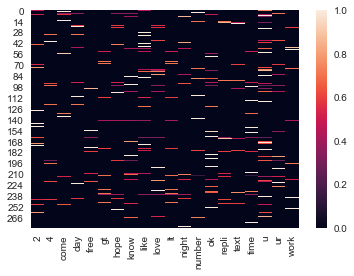

In [ ]:
import seaborn as sns; sns.set()
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(df3)
ax.figure.savefig("heatmap.png")

## Performing hierarchical clustering on a distance matrix

In [ ]:
from scipy.spatial.distance import pdist, squareform

row_dist = pd.DataFrame(squareform(pdist(df3.values, metric='euclidean')),
                        columns=index,
                        index=index)
print(row_dist)

          0         1         2         3         4         5         6    \
0    0.000000  0.687775  1.414214  1.414214  1.414214  1.205671  1.414214   
1    0.687775  0.000000  1.414214  1.414214  1.414214  1.133309  1.414214   
2    1.414214  1.414214  0.000000  1.414214  1.108918  1.014578  1.414214   
3    1.414214  1.414214  1.414214  0.000000  1.414214  1.414214  1.414214   
4    1.414214  1.414214  1.108918  1.414214  0.000000  1.275210  1.414214   
5    1.205671  1.133309  1.014578  1.414214  1.275210  0.000000  1.414214   
6    1.414214  1.414214  1.414214  1.414214  1.414214  1.414214  0.000000   
7    0.687775  0.000000  1.414214  1.414214  1.414214  1.133309  1.414214   
8    1.105997  1.190031  1.414214  1.414214  1.316118  1.338321  1.414214   
9    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
10   1.034177  1.414214  1.414214  1.414214  1.414214  1.414214  1.414214   
11   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

In [ ]:

from scipy.cluster.hierarchy import linkage

row_clusters = linkage(df3.values, method='single', metric='euclidean')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1)
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,1.0,7.0,0.000000,2.0
cluster 2,23.0,279.0,0.000000,3.0
cluster 3,28.0,280.0,0.000000,4.0
cluster 4,54.0,281.0,0.000000,5.0
cluster 5,84.0,282.0,0.000000,6.0
cluster 6,117.0,283.0,0.000000,7.0
cluster 7,142.0,284.0,0.000000,8.0
cluster 8,151.0,285.0,0.000000,9.0
cluster 9,170.0,286.0,0.000000,10.0
cluster 10,179.0,287.0,0.000000,11.0


## Display the Dendogram

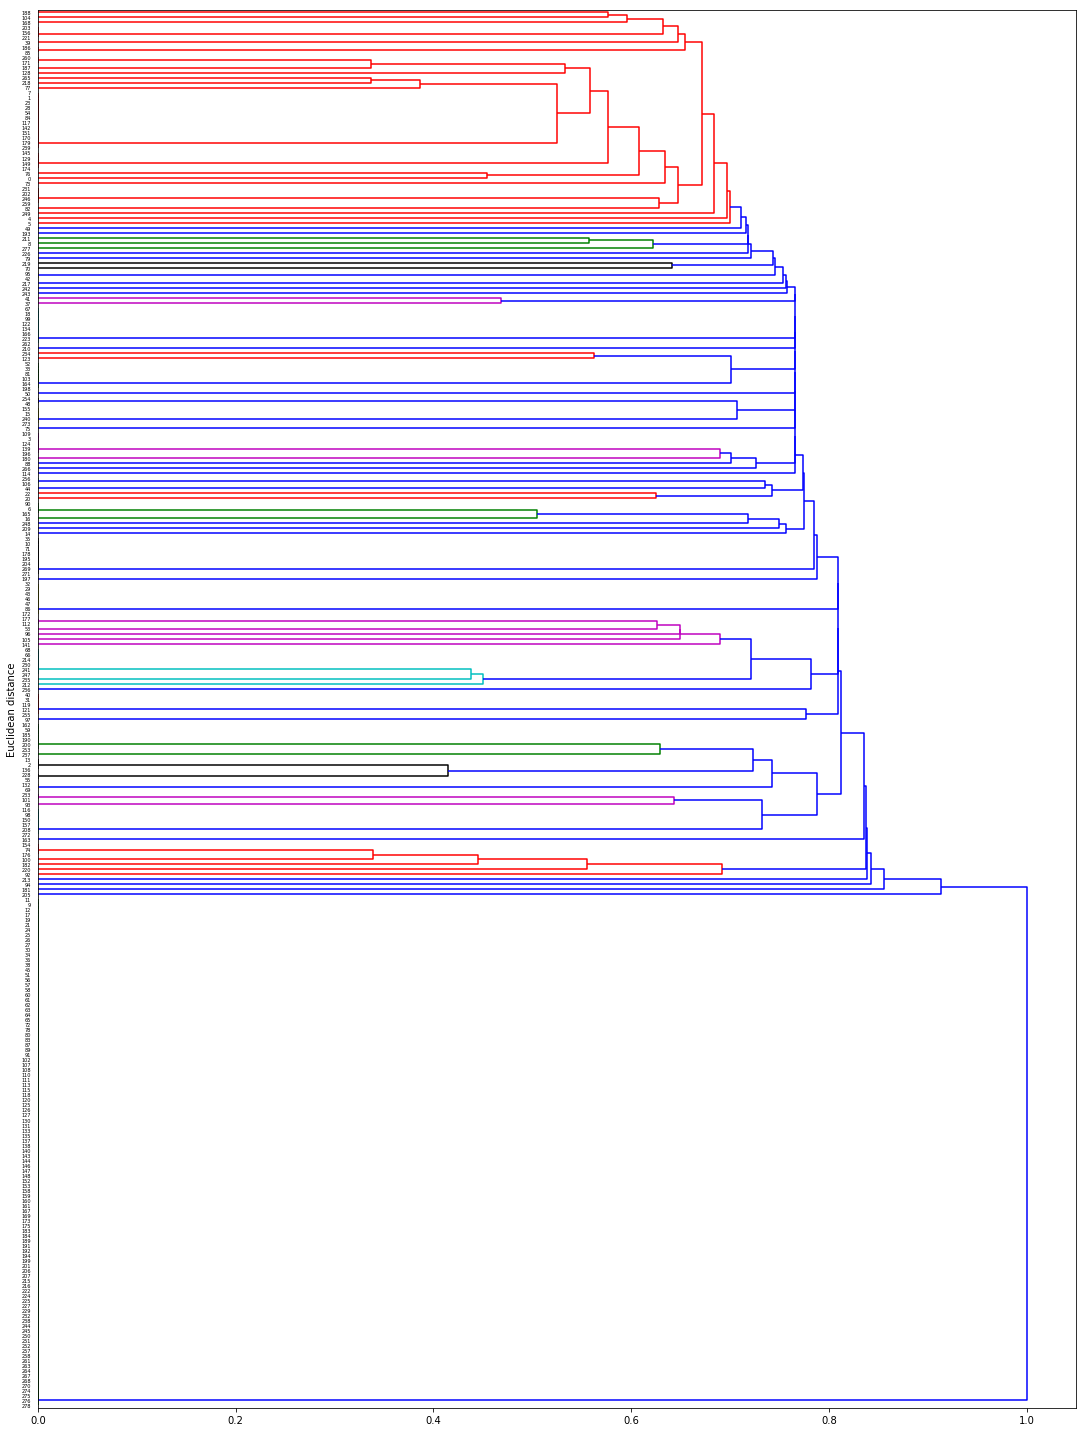

In [ ]:
from scipy.cluster.hierarchy import dendrogram

#make dendrogram black (part 1/2)
#from scipy.cluster.hierarchy import set_link_color_palette
#set_link_color_palette(['black'])

fig, row_dendr = plt.subplots(figsize=(15, 20)) # set size

row_dendr = dendrogram(row_clusters, 
                       labels=labels,
                       orientation="right",
                       # make dendrogram black (part 2/2)
                       # color_threshold=np.inf
                       )

plt.tight_layout()
plt.ylabel('Euclidean distance')
#plt.savefig('images/11_11.png', dpi=300, 
#            bbox_inches='tight')
plt.show()

## Exercise 
Change the linkage method from 'complete' to 'single' and create the dendogram. Do you notice any obvious differences? Single link tends to create straggly clusters compared to complete.

# Further visualisations with the seaborn library
seaborn provides some useful methods to display both the dendogram aswell as visualise the distances that led to the merging of instances (or text messages). 

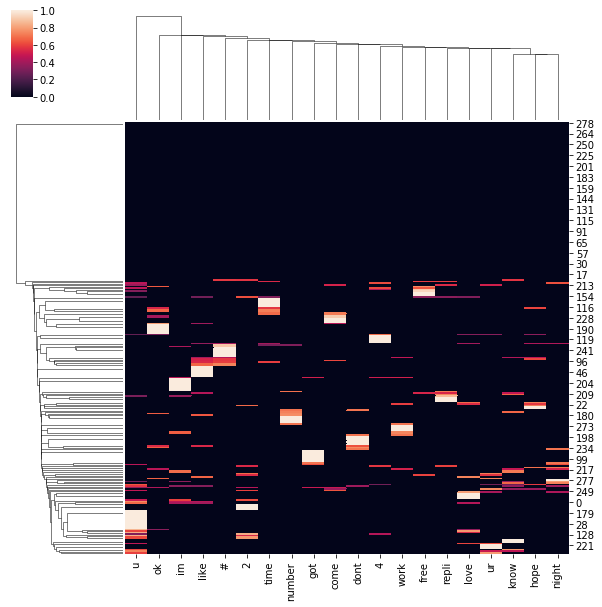

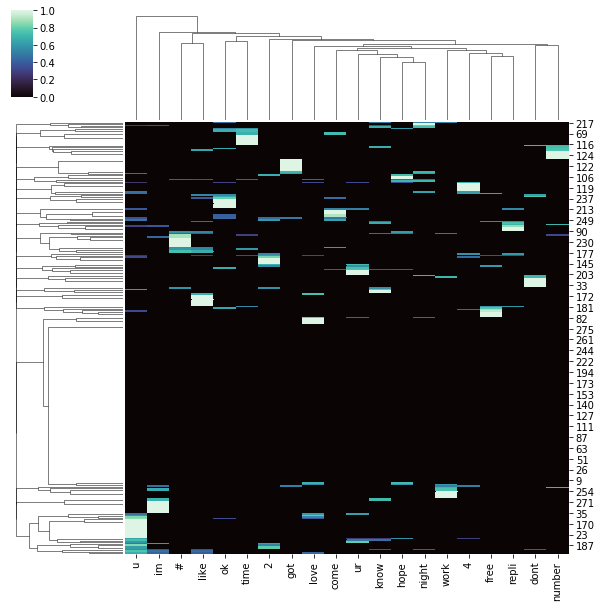

In [ ]:
# Libraries
import seaborn as sns

 
# Data set
df3
 
# draw the dendogram.
# there are several linkage methods that can be used here
sns.clustermap(df3, metric="euclidean", standard_scale=1, method="single")
sns.clustermap(df3, metric="euclidean", standard_scale=1, method="complete", cmap="mako")
#sns.clustermap(df3, metric="euclidean", standard_scale=1, method="average", cmap="viridis")
#sns.clustermap(df3, metric="euclidean", standard_scale=1, method="complete", cmap="Blues")


# Explorations

The code above can be used to cluster any text collection you might want to manage. 
For instance we could use it to cluster similar movies from synopsis; or we could cluster similar books from their abstracts; or cluster friends in a network based on similar postings etc. 